In [1]:
%matplotlib inline
import sys
sys.path.append('../')

import numpy
from experiments.data import make_weak_true_partition

from wlc.WLweakener import computeM

from sklearn.datasets import make_blobs, make_classification

from experiments.visualizations import plot_heatmap

import matplotlib.pyplot as plt

from matplotlib import cm

import theano

cmap = cm.get_cmap('Accent')

Using Theano backend.


# 1. Toy example

## 1.a. Generating random clean data

We will generate $N_{classes}$ classes comming each from a Gaussian distribution

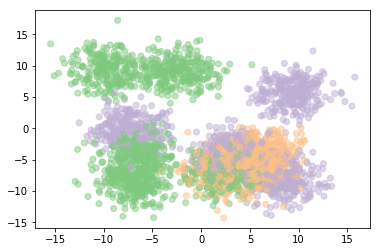

In [2]:
TOY_EXAMPLE = 'Nonseparable' # Gaussians, Classification
n_samples = 3000

n_features = 5
random_state = 42

if TOY_EXAMPLE == 'Separable':
    means = [[-1, -1],
             [-1,  1],
             [ 1,  1]]
    std = 1.0
    priors = numpy.array([.3, .3, .4])
    samples_per_class = (n_samples*priors).astype(int)
    X, y = make_blobs(n_samples=samples_per_class, n_features=n_features, centers=means,
                      cluster_std=std, random_state=random_state)
elif TOY_EXAMPLE == 'Nonseparable':
    std = 2.0
    X, y =  make_blobs(n_samples=n_samples, n_features=n_features, centers=12,
                       cluster_std=std, random_state=random_state)
    y[y < 5] = 0
    y[y > 7] = 1
    y[y > 1] = 2
elif TOY_EXAMPLE == 'toy3':
    n_classes = 3
    centers = numpy.random.rand(n_classes, n_features)*2.0
    cluster_std = numpy.abs(numpy.random.randn(n_classes)*2.0)
    X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers,
                      cluster_std=cluster_std, random_state=random_state)
else:
    raise KeyError('Toy example {} does not exist'.format(TOY_EXAMPLE))

n_classes = numpy.unique(y).shape[0]

plt.scatter(X[:,0], X[:,1], c=cmap(y), alpha=0.5)

## 1.b. Specifying the mixing process with a matrix M

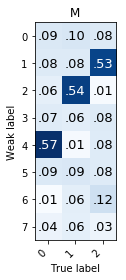

In [3]:
m_method = 'random_weak'
m_alpha = 0.7 # Alpha = 1.0 No unsupervised in IPL
m_beta = 0.5 # Beta = 0.0 No noise

M = computeM(c=n_classes, method=m_method, alpha=m_alpha, beta=m_beta)

fig = plot_heatmap(M, title='M', xlabel='True label', ylabel='Weak label')

## 1.c. Applying the mixing process to a portion of the clean data

- $S_w$ denotes the dataset with only weak labels
- $S_{wt}$ denotes the dataset with both weak and true labels
- $S_{wt-test}$ denotes the dataset with both weak and true labels but will be used only for test purposes

Weak set size = 1800
Weak/true training set size = 24
Weak/true test set size = 1176


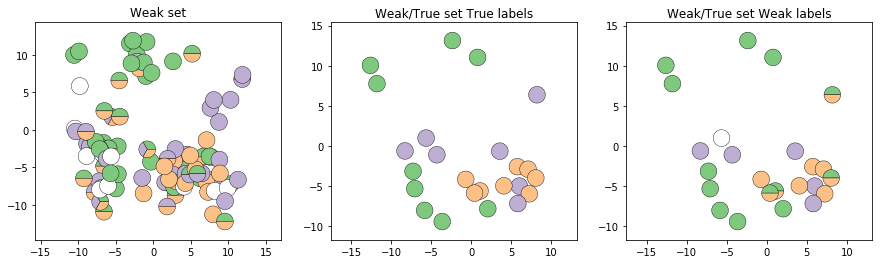

In [4]:
from experiments.visualizations import plot_multilabel_scatter
from sklearn.model_selection import train_test_split

true_proportion = 0.4 # proportion of data with true labels
test_proportion = 0.98 # proportion of data with true labels that will be used for test only

weak_set, weak_and_true_set, _, _ = make_weak_true_partition(M, X, y, true_size=true_proportion, random_state=42)
(X_w, Z_w, z_w, Y_w, y_w) = weak_set

splits = train_test_split(*weak_and_true_set, test_size=test_proportion)
X_wt_train, Z_wt_train, z_wt_train, Y_wt_train, y_wt_train = splits[0::2]
X_wt_test, Z_wt_test, z_wt_test, Y_wt_test, y_wt_test = splits[1::2]

print('Weak set size = ' + str(len(X_w)))
print('Weak/true training set size = {}'.format(len(X_wt_train)))
print('Weak/true test set size = {}'.format(len(X_wt_test)))


fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1)
_ = plot_multilabel_scatter(X_w[:100], Z_w[:100], fig=fig,
                            ax=ax, title='Weak set', cmap=cmap)
ax = fig.add_subplot(1, 3, 2)
_ = plot_multilabel_scatter(X_wt_train[:100], Y_wt_train[:100], fig=fig,
                            ax=ax, title='Weak/True set True labels', cmap=cmap)
ax = fig.add_subplot(1, 3, 3)
_ = plot_multilabel_scatter(X_wt_train[:100], Z_wt_train[:100], fig=fig,
                            ax=ax, title='Weak/True set Weak labels', cmap=cmap)

# 2. Baseline

Training a baseline classifier with only the true labels available for training


## 2.a. Scikit Learn Logistic Regression

Coefficients
[[-0.80269026  0.3560175   0.47147852 -0.6138124   0.25266013]
 [-0.04870411  0.04804433 -0.03708421  0.04956961 -0.09832849]
 [ 0.85139437 -0.40406183 -0.43439431  0.56424279 -0.15433164]]
Intercepts
[ 4.5667649   1.37370419 -5.94046909]


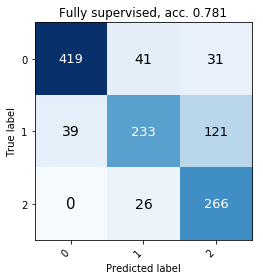

In [5]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', multi_class='multinomial')
clf.fit(X_wt_train, y_wt_train)

clf_proba = clf.predict_proba(X_wt_test)
clf_pred = clf_proba.argmax(axis=1)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_wt_test, clf_pred)

from experiments.visualizations import plot_confusion_matrix
_ = plot_confusion_matrix(cm, title='Fully supervised, acc. {:.3}'.format((y_wt_test == clf_pred).mean()))

print('Coefficients')
print(clf.coef_)
print('Intercepts')
print(clf.intercept_)

## 2.b. Definition of a Logistic Regression in Keras

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

_EPSILON = K.epsilon()

def make_model(loss):
    if hasattr(loss, '__name__'):
        print('Loss __name__ = {}'.format(loss.__name__))
    model = Sequential() 
    model.add(Dense(n_classes, input_dim=n_features, activation='softmax',
                bias_initializer='zeros',
                kernel_initializer='random_uniform')) 
    model.compile(optimizer='adam', loss=loss,
                  metrics=['accuracy', 'mean_squared_error',
                           'categorical_crossentropy'])
    return model

from keras.callbacks import EarlyStopping

max_epochs = 5000
batch_size = 256
patience = 100
early_stop_loss = 'val_mean_squared_error'

early_stopping = EarlyStopping(monitor=early_stop_loss, min_delta=0, patience=patience, 
                               verbose=0, mode='auto', baseline=None,
                               restore_best_weights=True)

## 2.c. Baseline with Keras

In [7]:
model = make_model('categorical_crossentropy')

history = model.fit(X_wt_train, Y_wt_train, 
                    validation_data=(X_wt_train, Y_wt_train),
                    epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                    batch_size=batch_size)

## 2.d. Plot results

We will define a function to plot the results, and we will use it later with the other methods

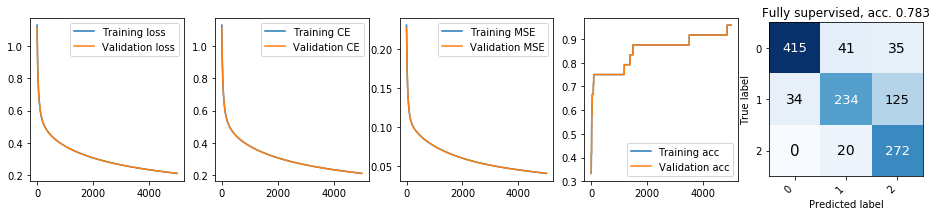

<Figure size 360x288 with 0 Axes>

In [8]:
def plot_results(model, X_test, y_test, history):
    clf_proba_wt_test = model.predict_proba(X_test)
    clf_pred_wt_test = numpy.argmax(clf_proba_wt_test, axis=1)
    cm = confusion_matrix(y_test, clf_pred_wt_test)

    from experiments.visualizations import plot_confusion_matrix
    fig = plt.figure(figsize=(16, 3))
    n_fig = 5
    ax = fig.add_subplot(1, n_fig, 1)
    _ = ax.plot(history.history['loss'], label='Training loss')
    _ = ax.plot(history.history['val_loss'], label='Validation loss')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 2)
    _ = ax.plot(history.history['categorical_crossentropy'], label='Training CE')
    _ = ax.plot(history.history['val_categorical_crossentropy'], label='Validation CE')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 3)
    _ = ax.plot(history.history['mean_squared_error'], label='Training MSE')
    _ = ax.plot(history.history['val_mean_squared_error'], label='Validation MSE')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 4)
    _ = ax.plot(history.history['acc'], label='Training acc')
    _ = ax.plot(history.history['val_acc'], label='Validation acc')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 5)
    acc = (y_test == clf_pred_wt_test).mean()
    _ = plot_confusion_matrix(cm, ax=ax, title='Fully supervised, acc. {:.3}'.format(acc))
    
plot_results(model, X_wt_test, y_wt_test, history)

# 3. Our proposed method

## 3.a. Estimate the mixing matrix $M_{0}$

We do an initial estimate of the mixing process of the weak set ussing the training available with both weak and true labels

../wlc/WLweakener.py:496: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  S[weak_list, :] = 1


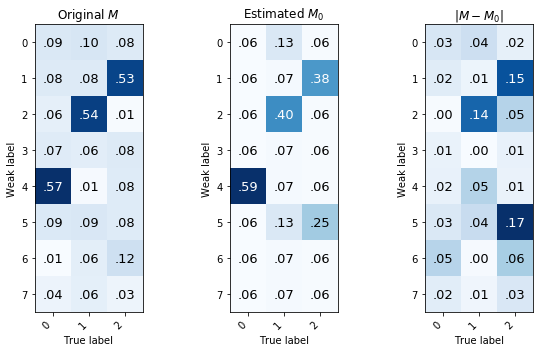

In [9]:
from wlc.WLweakener import estimate_M

M_0 = estimate_M(Z_wt_train, Y_wt_train, range(n_classes), reg='Partial', Z_reg=Z_w)

fig = plt.figure(figsize=(10, 5))
for i, (title, m) in enumerate([(r'Original $M$', M),
                                (r'Estimated $M_0$', M_0),
                                (r'$|M - M_0|$', numpy.abs(M - M_0))]):
    ax = fig.add_subplot(1,3,i+1)
    fig = plot_heatmap(m, title=title, fig=fig, ax=ax,
                       xlabel='True label', ylabel='Weak label')

## 3.b. Combine the mixing matrices

We define the mixing matrix for the dataset with true labels with a perfect identity matrix $M_1 = I$. And create the final mixing matrix by concatenating and scaling both mixing matrices by $q_d$

$$M_{EM} = \binom{q_0 M_0}{q_1 I}$$

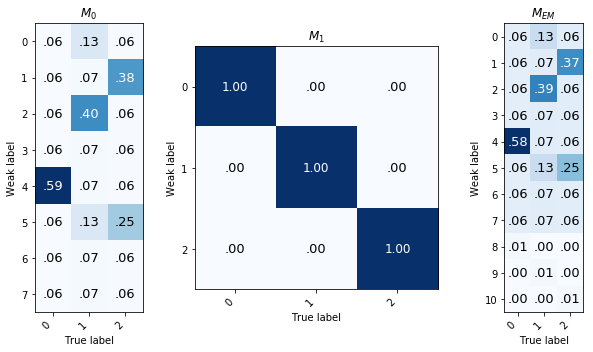

In [10]:
M_1 = computeM(c=n_classes, method='supervised')
q_0 = len(X_w)/ float(len(X_w) + len(X_wt_train))
q_1 = len(X_wt_train)/ float(len(X_w) + len(X_wt_train))
M_EM = numpy.concatenate((q_0*M_0, q_1*M_1))

fig = plt.figure(figsize=(10, 5))
for i, (title, m) in enumerate([('$M_0$', M_0), ('$M_1$', M_1), ('$M_{EM}$', M_EM)]):
    ax = fig.add_subplot(1,3,i+1)
    fig = plot_heatmap(m, title=title, fig=fig, ax=ax,
                       xlabel='True label', ylabel='Weak label')

## 3.c. Count of every indice in the training set

The following plots show the count of every weak label in the set with only Weak labels, and the set with weak and true labels

Example of true labels
[2 0 1 1 2]
[[0 0 1]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]]
Corresponding indices to the matrix
[10  8  9  9 10]
Example of weak labels
[[0 1 1]
 [1 0 0]
 [1 1 1]
 [0 1 1]
 [0 0 1]]
Corresponding indices to the matrix
[3 4 7 3 1]


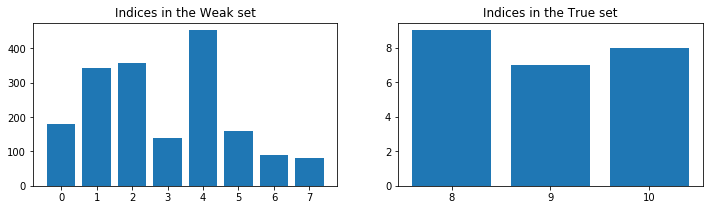

In [11]:
from wlc.WLweakener import weak_to_index
from collections import Counter

Z_w_index = weak_to_index(Z_w, method='Mproper')
Y_wt_index = weak_to_index(Y_wt_train, method='supervised') + len(M_0)

print('Example of true labels')
print(y_wt_train[:5])
print(Y_wt_train[:5])
print('Corresponding indices to the matrix')
print(Y_wt_index[:5])

print('Example of weak labels')
print(Z_w[:5])
print('Corresponding indices to the matrix')
print(Z_w_index[:5])

fig = plt.figure(figsize=(12, 3))
for i, (title, indices) in enumerate([('Indices in the Weak set', Z_w_index),
                                      ('Indices in the True set', Y_wt_index)]):
    labels, values = zip(*sorted(Counter(indices).items()))
    indexes = range(len(labels))
    ax = fig.add_subplot(1, 2, i+1)
    ax.set_title(title)
    ax.bar(indexes, values)
    ax.set_xticks(indexes)
    ax.set_xticklabels(labels)

## 3.d. Sample of weak samples using $M_{EM}$

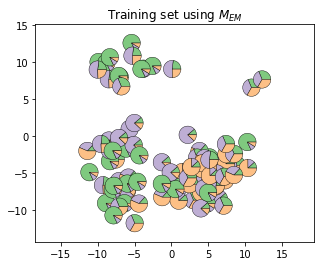

In [12]:
from sklearn.utils import shuffle

Z_index_train = numpy.concatenate((Z_w_index, Y_wt_index))

X_train = numpy.concatenate((X_w, X_wt_train))

X_train, Z_index_train = shuffle(X_train, Z_index_train)

Z_train = numpy.array(M_EM[Z_index_train])

fig = plt.figure(figsize=(5, 4))
_ = plot_multilabel_scatter(X_train[:100], Z_train[:100], title='Training set using $M_{EM}$', cmap=cmap, fig=fig)

## 3.e. Training with Expectation Maximization

### 3.e.E-step: Expectation step

$$q_k^{(t)} = \frac{diag(f_k^{(t)}) M^T z_k}{z_k^T M f_k^{(t)}}$$

### 3.e.M-step: Maximization step

$$W^{(t+1)} = W^{(t)} + \rho^{(t)} \sum_{k=0}^{K-1} \left(q_k^{(t)} - f_k^{(t)}\right) x_k^T$$

where $\rho^{(t)}$ is the learning step

Loss __name__ = log_loss


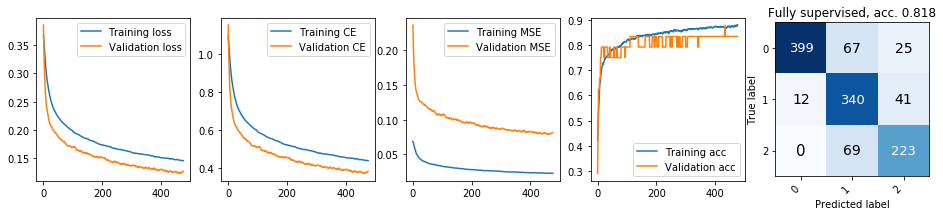

<Figure size 360x288 with 0 Axes>

In [13]:
def log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    out = -y_true*K.log(y_pred)
    return K.mean(out, axis=-1)

model = make_model(log_loss)

history.history = {}
for epoch in range(max_epochs):
    proba_train = model.predict_proba(X_train)
    Q = numpy.multiply(proba_train, Z_train)
    Z_em_train = Q / numpy.sum(Q, axis=1).reshape(-1, 1)
    is_finite = numpy.isfinite(numpy.sum(Z_em_train, axis=1))
    
    if not numpy.all(is_finite):
        print('Some rows are NaN')
        
    index_is_finite = numpy.where(is_finite)[0]
    
    history_aux = model.fit(X_train[index_is_finite], Z_em_train[index_is_finite], 
                            validation_data=(X_wt_train, Y_wt_train), 
                            epochs=1, verbose=0, batch_size=batch_size)
    for key, value in history_aux.history.items():
        if epoch == 0:
            history.history[key] = [value]
        else:
            history.history[key].append(value)
    if epoch > patience and numpy.mean(history.history[early_stop_loss][-patience:-1]) < history.history[early_stop_loss][-1]:
        break

plot_results(model, X_wt_test, y_wt_test, history)

# 4. New implementation only defining the loss

Loss __name__ = EM_log_loss


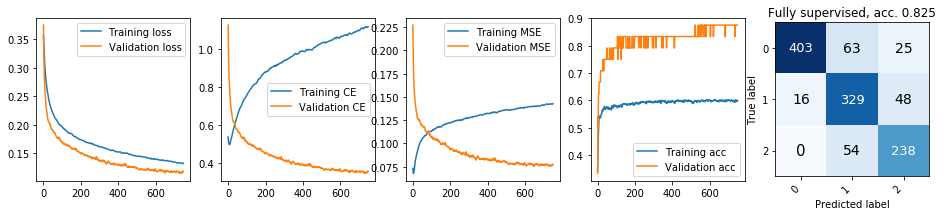

<Figure size 360x288 with 0 Axes>

In [14]:
def EM_log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    Q = y_true * y_pred
    Z_em_train = Q / Q.sum(axis=-1, keepdims=True)
    out = -K.stop_gradient(Z_em_train)*K.log(y_pred)
    return K.mean(out, axis=-1)

model = make_model(EM_log_loss)

history = model.fit(X_train, Z_train, 
                    validation_data=(X_wt_train, Y_wt_train),
                    epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                    batch_size=batch_size)

plot_results(model, X_wt_test, y_wt_test, history)